In [6]:
import quartz
import time
import heapq
from concurrent.futures import ProcessPoolExecutor
import json
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import math
from collections import deque

In [7]:
global fn
fn = 't_tdg_h_cx_toffoli_flip_dataset/barenco_tof_3_after_toffoli_flip.qasm'


def check(graph):
    graph.to_qasm(filename='check.qasm')
    qc_origin = QuantumCircuit.from_qasm_file(fn)
    qc_optimized = QuantumCircuit.from_qasm_file('check.qasm')
    return Statevector.from_instruction(qc_origin).equiv(
        Statevector.from_instruction(qc_optimized))


quartz_context = quartz.QuartzContext(
    gate_set=['h', 'cx', 't', 'tdg', 'x'],
    filename='../bfs_verified_simplified.json',
    no_increase=False)
print(f'number of xfers: {quartz_context.num_xfers}')
parser = quartz.PyQASMParser(context=quartz_context)
init_dag = parser.load_qasm(filename=fn)
init_graph = quartz.PyGraph(context=quartz_context, dag=init_dag)

number of xfers: 3517


In [ ]:
candidate_hq = []
heapq.heappush(candidate_hq, init_graph)
hash_set = set()
predecessor_dict = {}
hash_set.add(init_graph.hash())
best_graph = init_graph
best_gate_cnt = init_graph.gate_count
#####
max_gate_cnt = best_gate_cnt * 1.05
budget = 5_000_000

stop = False
hash_38 = None

start = time.time()

while not stop and candidate_hq != [] and budget >= 0:
    first_graph = heapq.heappop(candidate_hq)
    all_nodes = first_graph.all_nodes()
    first_cnt = first_graph.gate_count

    def ax(i):
        node = all_nodes[i]
        return first_graph.available_xfers(context=quartz_context, node=node)

    with ProcessPoolExecutor(max_workers=32) as executor:
        results = executor.map(ax, list(range(len(all_nodes))), chunksize=3)
        appliable_xfers_nodes = []
        for r in results:
            appliable_xfers_nodes.append(r)

    for i in range(len(all_nodes)):
        node = all_nodes[i]
        appliable_xfers = appliable_xfers_nodes[i]
        for xfer in appliable_xfers:
            new_graph = first_graph.apply_xfer(
                xfer=quartz_context.get_xfer_from_id(id=xfer), node=node)
            new_hash = new_graph.hash()
            if new_graph.gate_count > max_gate_cnt:
                continue
            if new_hash not in hash_set:
                new_cnt = new_graph.gate_count
                hash_set.add(new_hash)
                predecessor_dict[new_hash] = (first_graph.hash(), i, xfer)
                heapq.heappush(candidate_hq, new_graph)
                if new_cnt < best_gate_cnt:
                    best_graph = new_graph
                    best_gate_cnt = new_cnt
                budget -= 1
                if budget % 10_000 == 0:
                    print(
                        f'{budget}: minimum gate count is {best_gate_cnt}, after {time.time() - start:.2f} seconds'
                    )
                if new_cnt == 38:
                    stop = True
                    hash_38 = new_hash

In [7]:
pre_hash = hash_38
path_info = []
while pre_hash != init_graph.hash():
    path_info.insert(0, predecessor_dict[pre_hash])
    pre_hash = predecessor_dict[pre_hash][0]
path_info

[(2736902812030104155, 7, 438),
 (18313387496586521224, 9, 438),
 (1331621069885951876, 55, 3122),
 (1103897301093208670, 51, 3122),
 (2493763946937623453, 50, 3122),
 (13712660118610526483, 28, 3289),
 (10205269208799562956, 7, 3245),
 (14755272681777216984, 49, 438),
 (6920926653460915766, 51, 438),
 (11516024265382157133, 39, 3122),
 (15496572576559184627, 34, 438),
 (5346246176610684611, 22, 3367),
 (6187405868450787861, 24, 1167),
 (18222811340221035117, 44, 1328),
 (14429511704610533490, 46, 1488),
 (4116237310049769111, 43, 988),
 (742855539106194158, 14, 2257),
 (15855938141789196426, 32, 3289),
 (18365771061176905318, 41, 1902),
 (3230177081155325340, 40, 981),
 (18428602068384667715, 20, 3289),
 (10913907499403761641, 5, 438),
 (4039698890560466799, 29, 438),
 (16534003522860835773, 9, 3187),
 (2647415650077068826, 31, 3174),
 (655509211213699210, 27, 3122),
 (5022748195509465535, 9, 3186),
 (12279444317663238965, 23, 3122),
 (11698397537717251075, 32, 3093),
 (77515076886963

In [8]:
path_info = [(2736902812030104155, 7, 438),
 (18313387496586521224, 9, 438),
 (1331621069885951876, 55, 3122),
 (1103897301093208670, 51, 3122),
 (2493763946937623453, 50, 3122),
 (13712660118610526483, 28, 3289),
 (10205269208799562956, 7, 3245),
 (14755272681777216984, 49, 438),
 (6920926653460915766, 51, 438),
 (11516024265382157133, 39, 3122),
 (15496572576559184627, 34, 438),
 (5346246176610684611, 22, 3367),
 (6187405868450787861, 24, 1167),
 (18222811340221035117, 44, 1328),
 (14429511704610533490, 46, 1488),
 (4116237310049769111, 43, 988),
 (742855539106194158, 14, 2257),
 (15855938141789196426, 32, 3289),
 (18365771061176905318, 41, 1902),
 (3230177081155325340, 40, 981),
 (18428602068384667715, 20, 3289),
 (10913907499403761641, 5, 438),
 (4039698890560466799, 29, 438),
 (16534003522860835773, 9, 3187),
 (2647415650077068826, 31, 3174),
 (655509211213699210, 27, 3122),
 (5022748195509465535, 9, 3186),
 (12279444317663238965, 23, 3122),
 (11698397537717251075, 32, 3093),
 (7751507688696329685, 5, 1169),
 (12468402432154714081, 7, 3367),
 (3940374301191074623, 5, 3187),
 (17158746403593706860, 30, 1112),
 (5430324642786857504, 6, 1168),
 (740785260983116808, 3, 3186),
 (7517094484506666681, 8, 438),
 (6281393612181272140, 28, 438),
 (10379171910497750749, 7, 3186),
 (17373826893216990654, 3, 1168),
 (13056658015607443228, 8, 3186),
 (12284550773704683536, 23, 3123),
 (16121769467923960676, 25, 3123),
 (15096561208649301315, 29, 3123),
 (9843785463694878021, 31, 3123),
 (9281599916742127965, 3, 1169),
 (10476847691448878400, 29, 438),
 (15256357852960636711, 25, 1112),
 (15336059965369103922, 7, 438),
 (3045063612125151839, 9, 3187),
 (5022848250050290636, 7, 3187),
 (10984121136545192345, 8, 438),
 (13429509792628469484, 25, 3093),
 (12258376817605383313, 5, 3187),
 (515792628368649871, 27, 438),
 (16970455580680144963, 8, 438),
 (10257026663347055629, 1, 3187),
 (9196754454164811498, 6, 1169),
 (2602778737100294203, 27, 438),
 (15263961106591946844, 23, 1112),
 (5200763921101556093, 23, 3093),
 (14353549282349255127, 0, 3186),
 (14911812804170303052, 6, 1166),
 (4062429576589971901, 3, 3366),
 (17976147425517117616, 23, 3093),
 (8823362064269418582, 12, 438),
 (4768033659585443585, 10, 2077),
 (3172852003950378990, 26, 3188),
 (18077113829645139005, 27, 1954),
 (15105892615542601103, 5, 3367),
 (7847132985929968324, 26, 1136),
 (17470574272081289858, 35, 985),
 (16142328690127687549, 25, 438),
 (10998660049978082072, 27, 981),
 (12475897916385443331, 23, 3123),
 (418708928086091715, 28, 988),
 (16644200867890788800, 3, 3366),
 (18100823425039284671, 3, 438),
 (1843180190355107907, 5, 438),
 (1626680820048640558, 1, 1168),
 (3534795522493352362, 6, 3186),
 (14421375056654928808, 26, 1154),
 (8408591719711169353, 22, 2738),
 (3280249187906061037, 22, 1715),
 (2794525778150980139, 20, 438),
 (9727057830094331240, 4, 446),
 (13649500350856685066, 3, 2175),
 (12581349176779856312, 3, 940),
 (11925816604849238101, 0, 1139),
 (11219651419413935772, 2, 3122),
 (8772198119317464574, 8, 3187),
 (6488731983653203999, 5, 1084),
 (12607051982761087667, 3, 1173),
 (14651410741105697437, 6, 3274)]

In [9]:
from qiskit import QuantumCircuit

graph = init_graph
circ = QuantumCircuit.from_qasm_str(graph.to_qasm_str())
circ.draw(output='mpl')

for i, (_, node, xfer) in enumerate(path_info):
    new_graph = graph.apply_xfer(xfer=quartz_context.get_xfer_from_id(id=xfer), node=graph.get_node_from_id(id=node))
    print(f'{new_graph.gate_count}, {node}, {xfer}, {graph.gate_count - new_graph.gate_count}')
    graph = new_graph
    print('src str: ')
    print(quartz_context.get_xfer_from_id(id=xfer).src_str)
    print('dst str: ')
    print(quartz_context.get_xfer_from_id(id=xfer).dst_str)

    circ = QuantumCircuit.from_qasm_str(graph.to_qasm_str())
    circ.draw(output='mpl').savefig(f'barenco_tof_3_path_2_39/step_{i}.png')

    

58, 7, 438, 0
src str: 
cx 0 1
cx 0 2

dst str: 
cx 0 2
cx 0 1

58, 9, 438, 0
src str: 
cx 0 1
cx 0 2

dst str: 
cx 0 2
cx 0 1

58, 55, 3122, 0
src str: 
cx 1 0
tdg 1

dst str: 
tdg 1
cx 1 0

58, 51, 3122, 0
src str: 
cx 1 0
tdg 1

dst str: 
tdg 1
cx 1 0

58, 50, 3122, 0
src str: 
cx 1 0
tdg 1

dst str: 
tdg 1
cx 1 0

56, 28, 3289, 2
src str: 
t 0
cx 0 1
tdg 0

dst str: 
cx 0 1

56, 7, 3245, 0
src str: 
cx 1 0
tdg 0
cx 1 0

dst str: 
cx 0 1
tdg 1
cx 0 1

56, 49, 438, 0
src str: 
cx 0 1
cx 0 2

dst str: 
cx 0 2
cx 0 1

56, 51, 438, 0
src str: 
cx 0 1
cx 0 2

dst str: 
cx 0 2
cx 0 1

56, 39, 3122, 0
src str: 
cx 1 0
tdg 1

dst str: 
tdg 1
cx 1 0

56, 34, 438, 0
src str: 
cx 0 1
cx 0 2

dst str: 
cx 0 2
cx 0 1

56, 22, 3367, 0
src str: 
cx 1 0
tdg 0
cx 1 0
t 0

dst str: 
t 0
cx 1 0
tdg 0
cx 1 0

56, 24, 1167, 0
src str: 
cx 2 0
tdg 0
cx 2 0
cx 0 1

dst str: 
cx 0 1
cx 2 0
tdg 0
cx 2 0

55, 44, 1328, 1
src str: 
cx 2 1
cx 2 0
tdg 0
cx 1 0
cx 2 1

dst str: 
cx 2 0
tdg 0
cx 1 0
cx 2 0

54, 4

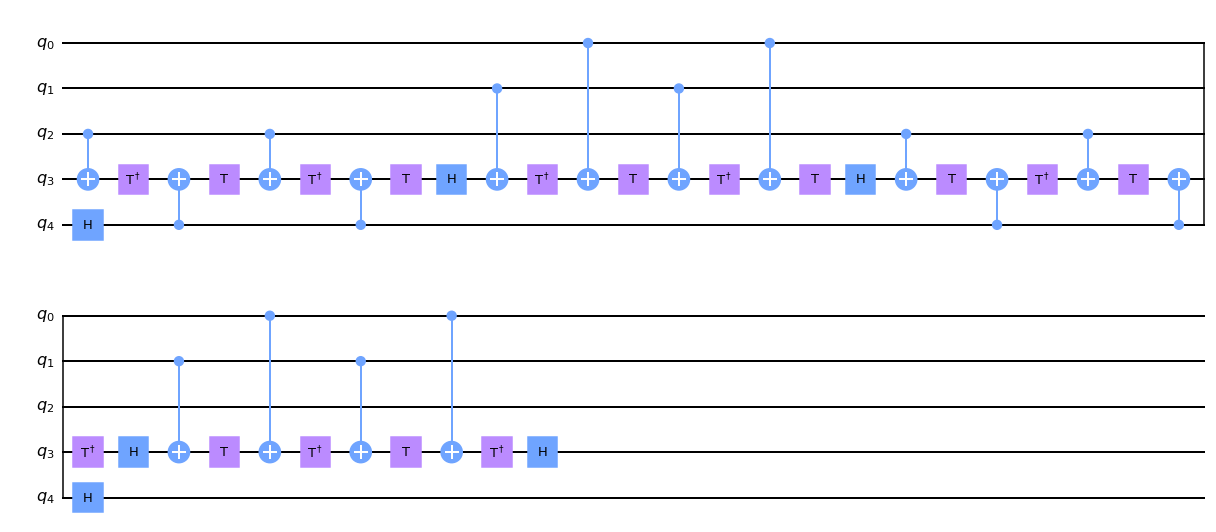

In [6]:
circ = QuantumCircuit.from_qasm_str(graph.to_qasm_str())
circ.draw(output='mpl')